# Modelo

### Profile Wall
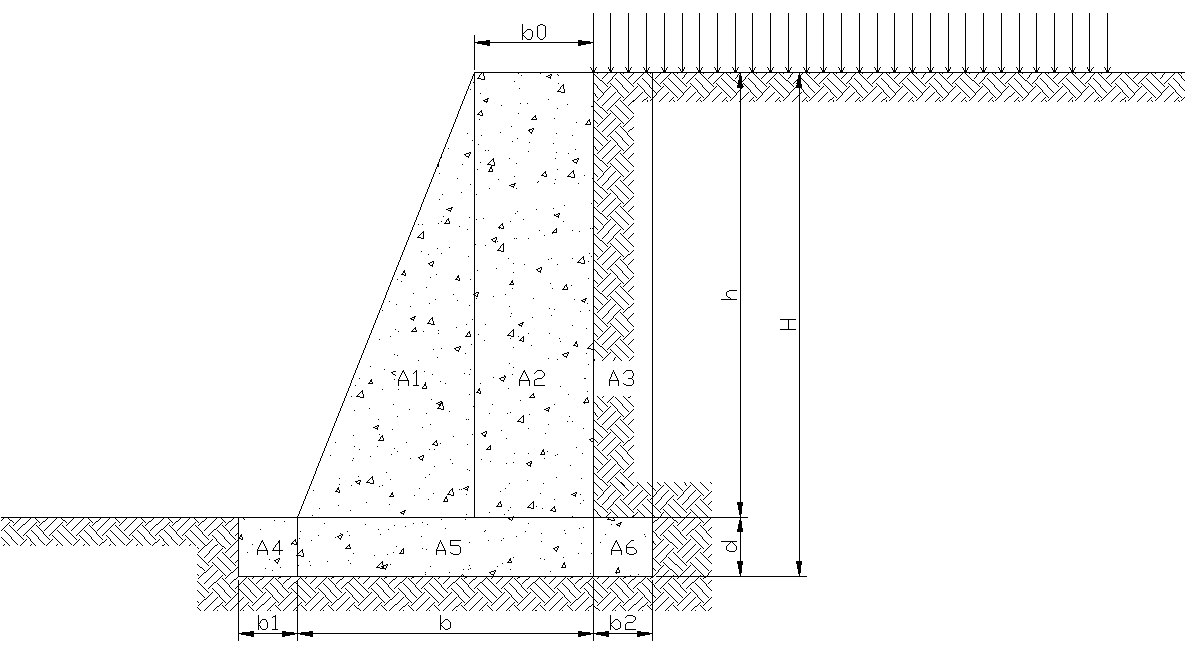


In [59]:
import numpy as np

def ActiveThrust(top_stress,H,y_nat,phi,c):
    # Fator de empuxo ativo do solo
    ka = np.tan(np.radians(45-(phi*0.5)))**2

    # Empuxo
    # Tensão Vertical
    sigma_v0 = top_stress
    sigma_v1 = top_stress + (y_nat*H)

    # Tensão Horizontal
    sigma_h0 = (ka*sigma_v0)-(2*c*np.sqrt(ka))
    sigma_h1 = (ka*sigma_v1)-(2*c*np.sqrt(ka))

    # Altura Crítica
    z_crit = (2*c*np.sqrt(ka))/(y_nat*ka) - (top_stress/y_nat)   

    # Empuxo Ativo e ponto de aplicação
    AT = (H-z_crit)*sigma_h1*0.5
    yAT = (H-z_crit)/3

    return AT,yAT

def PassiveThrust(top_stress,H,y_nat,phi,c):
    if H != 0:
        # Fator de empuxo ativo do solo
        kp = np.tan(np.radians(45+(phi*0.5)))**2

        # Empuxo
        # Tensão Vertical
        sigma_v0 = top_stress
        sigma_v1 = top_stress + (y_nat*H)

        # Tensão Horizontal
        sigma_h0 = (kp*sigma_v0)+(2*c*np.sqrt(kp))
        sigma_h1 = (kp*sigma_v1)+(2*c*np.sqrt(kp))
        

        # Empuxo Ativo e ponto de aplicação
        PT = H*(sigma_h0 + sigma_h1)*0.5
        yPT = ((sigma_h0*H*H*0.5) + ((sigma_h1-sigma_h0)*H*0.5*(H/3)))/PT

    else:
        PT = 0
        yPT = 0

    return PT,yPT

def GravityRetainingWall(h,b,b0,b1,b2,d,y_w,y_nat):
    '''
    Verificar dimensões no diagrama da figura
    '''

    if d != 0:
        A1 = (b-b0)*h*0.5*y_w
        x1 = b1 + ((b-b0)*(2/3))

        A2 = b0*h*y_w
        x2 = b1 + (b-b0) + (b0*0.5)

        # A3 é solo
        A3 = b2*h*y_nat
        x3 = b1 + b + (b2*0.5)

        A4 = b1*d*y_w
        x4 = b1*0.5

        A5 = b*d*y_w
        x5 = b1 + (b*0.5)

        A6 = b2*d*y_w
        x6 = b1 + b + (b2*0.5)

        W = A1+A2+A3+A4+A5+A6
        xw = ((A1*x1)+(A2*x2)+(A3*x3)+(A4*x4)+(A5*x5)+(A6*x6))/W
    
    else:
        A1 = (b-b0)*h*0.5*y_w
        x1 = b1 + ((b-b0)*(2/3))

        A2 = b0*h*y_w
        x2 = b1 + (b-b0) + (b0*0.5)

        W = A1+A2
        xw = ((A1*x1)+(A2*x2))/W

    return W, xw

def DesignAnalysis(
    W,
    xw,
    b,
    AT,
    yAT,
    PT,
    yPT,
    f,
    q_adm,
    FSt_adm=1.5,
    FSe_adm=1.5,
    FSr_adm=2.5,
    logs=True):

    # Verificações de estabilidade
    # Estabilidade ao tombamento
    FSt = np.round(((W*xw)+(Ep*yp))/(Ea*ya),2)

    # Estabilidade ao escorregamento
    FSe = np.round(((W*f)+Ep)/Ea,2)

    # Estabilidade à ruptura da fundação
    e_ = ((W*xw)+(Ep*yp)-(Ea*ya))/W

    if (e_ < b/3) or (e_ > (2/3)*b):
        q = (2*W)/(3*e_)
    else:
        e = (b*0.5) - e_
        q = (W/b)*(1+((6*e)/b))

    FSr = np.round(q_adm/q,2)

    if logs:
        # Resultados
        print(f'Estabilidade ao tombamento FS = {FSt} ' + (f'≥ {FSt_adm} - Estável' if FSt >=FSt_adm else f'< {FSt_adm} - Instável'))
        print(f'Estabilidade ao escorregamento FS = {FSe} ' + (f'≥ {FSe_adm} - Estável' if FSe >=FSe_adm else f'< {FSe_adm} - Instável'))
        print(f'Estabilidade à ruptura da fundação FS = {FSr} ' + (f'≥ {FSr_adm} - Estável' if FSr >=FSr_adm else f'< {FSr_adm} - Instável'))
    
    return True if (FSt>=FSt_adm) & (FSe>=FSe_adm) & (FSr>=FSr_adm) else False

In [60]:
# ------------------------------Rotina de cálculo-------------------------------

# Características do muro
y_w = 24 # peso específico do material kN/m3
h = 3 # m
b = 0.6 # m
b0 = 0.3 # m
b1 = 0 # m
b2 = 0 # m
d = 0.5 # m

# Características do solo
y_nat = 20 # kN/m3
phi = 30 # °
c = 10 # kPa

f = np.tan(np.radians(phi)) # Fator de atrito da fundação
q_adm = 300 # Tensão de ruptura da fundação em kN/m2

# Esforço Inicial
top_stress = 10

# Fatores de segurança mínimos
FSt_adm = 1.5
FSe_adm = 1.5
FSr_adm = 2.5

# ------------------------------Cálculo dos Elementos---------------------------
W, xw = GravityRetainingWall(h=h,b=b,b0=b0,b1=b1,b2=b2,d=d,y_w=y_w,y_nat=y_nat)

# Empuxo Ativo
Ea, ya = ActiveThrust(
    top_stress=top_stress,
    H=h+d,
    y_nat=y_nat,
    phi=phi,
    c=c
    )

# Empuxo Passivo
Ep, yp = PassiveThrust(
    top_stress=top_stress,
    H=d,
    y_nat=y_nat,
    phi=phi,
    c=c
    )

DesignAnalysis(
    W=W,
    xw=xw,
    b=b+b1+b2,
    AT=Ea,
    yAT=ya,
    PT=Ep,
    yPT=yp,
    f=f,
    q_adm=q_adm,
    FSt_adm=1.5,
    FSe_adm=1.5,
    FSr_adm=2.5,
    logs=True)

Estabilidade ao tombamento FS = 1.8 ≥ 1.5 - Estável
Estabilidade ao escorregamento FS = 3.66 ≥ 1.5 - Estável
Estabilidade à ruptura da fundação FS = 3.31 ≥ 2.5 - Estável


True